In [53]:
import torch
import glob

def data_sampler(path_1, path_2):
    #path_2 = r'C:\Users\wtana\Desktop\LiDAR_cm\syoumen\kaneko\200cm\txt\*'
    true_files = glob.glob(path_1)
    false_files = glob.glob(path_2)
    
    len_true = len(true_files)
    len_false = len(false_files)
    if len_true == 0 or len_false == 0:
        print('No data available')
        return 0,0

    true_list = []
    false_list = []

    for idx in range(64):
        s_num = []
        with open(true_files[idx],'r') as f:
            data = f.read().split('\n')
            for i in range(len(data)-1):
                s = data[i].split(' ')
                s_num.append([float(s[0]),float(s[1]),float(s[2])])
        true_list.append([s_num])

    for idx in range(64):
        s_num = []
        with open(false_files[idx],'r') as f:
            data = f.read().split('\n')
            for i in range(len(data)-1):
                s = data[i].split(' ')
                s_num.append([float(s[0]),float(s[1]),float(s[2])])
        false_list.append([s_num])
    #len_true = len(true_list)
    #len_false = len(false_list)

    true_labels = torch.ones(32)
    false_labels = torch.zeros(32)

    input_data = torch.cat((torch.Tensor(true_list),torch.Tensor(false_list)),dim=0)
    labels = torch.cat((torch.Tensor(true_labels), torch.Tensor(false_labels)),dim=0)
    return input_data.view(-1,3), labels.view(-1, 1)

In [60]:
from model import *
#from sampler import *
#from self_made import *
import time

loss = []
Accu = []

batch_size = 64
num_points = 64
num_labels = 1
def main_(path_1,path_2,epoch):
    s_time = time.time()
    pointnet = PointNet(num_points, num_labels)

    #new_param = pointnet.state_dict()
    #new_param['main.0.main.6.bias'] = torch.eye(3, 3).view(-1)
    #new_param['main.3.main.6.bias'] = torch.eye(64,64).view(-1)
    #pointnet.load_state_dict(new_param)
    pointnet.load_state_dict(torch.load('./human_tree.pth'))
    criterion = nn.BCELoss()
    optimizer = optim.Adam(pointnet.parameters(), lr=0.001)

    for _ in range(epoch+1):

        pointnet.zero_grad()
        input_data, labels = data_sampler(path_1,path_2)
        #input_data, labels = data_sampler(batch_size, num_points)

        output = pointnet(input_data)
        output = nn.Sigmoid()(output)

        error = criterion(output, labels)
        error.backward()

        optimizer.step()

        with torch.no_grad():
            output[output > 0.5] = 1
            output[output < 0.5] = 0
            accuracy = (output==labels).sum().item()/batch_size

        loss.append(float(error.item()))
        Accu.append(float(accuracy))
        #if iteration % 10 == 0:

            #print('Iteration : {}   Loss : {}'.format(iteration, error.item()))
            #print('Iteration : {}   Accuracy : {}'.format(iteration, accuracy))
    #torch.save(pointnet.state_dict(), './model_2.pth')
    return pointnet

In [61]:
pointnet = main_('./normalize_txt/takuya/150cm/*','./normalize_txt/tree/*',20)
torch.save(pointnet.state_dict(), './human_tree.pth')

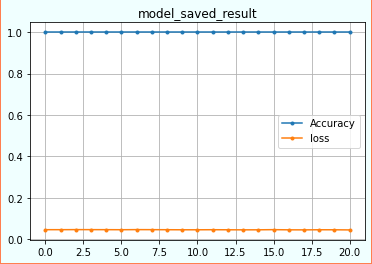

In [62]:
import matplotlib.pyplot as plt
x = range(0,len(Accu))

plt.figure(facecolor="azure", edgecolor="coral", linewidth=2)
plt.plot(x,Accu,marker='.',label='Accuracy')
plt.plot(x,loss,marker='.',label='loss')
plt.title('model_saved_result')
plt.grid('TRUE')
plt.legend()

In [34]:
sum = 0.0
for a in Accu:
    sum = sum + a
print(sum / len(Accu))

1.0


In [37]:
a,b = data_sampler('./normalize_txt/takuya/150cm/*','./normalize_txt/tree/*')

In [40]:
len(b)

32